<a href="https://colab.research.google.com/github/176567/deeplearning/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22AIT_09_Author_classification_assessment%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Use this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Author classification
The task is to train a 1D CNN or an LSTM that is able to  classify text from two authors. The final model should be able to tell about a text with a given length (e.g. 60 characters) who wrote it.

Please write the codes according to the following parts:

## Python module imports
Import all Python modules that you would need during the Assignment.

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

## Data acquisition
Seek a possible dataset, you can use any source, e.g.
* http://www.gutenberg.org/
* https://www.kaggle.com/datasets
* https://paperswithcode.com/datasets
* if you would like to learn Hungarian, than e.g. https://mek.oszk.hu/

You can download the text by hand (e.g. by copy-pasting some parts into txt files) or with Python.

In [18]:
import requests

def download_text(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print("Failed to download the text.")
        return None

# Example: Downloading "Pride and Prejudice" by Jane Austen
url = "http://www.gutenberg.org/cache/epub/73504/pg73504.txt"
url2 = "http://www.gutenberg.org/cache/epub/73508/pg73508.txt"
text = download_text(url)
text2 = download_text(url2)

if text:
    # Save the text to a file
    with open("pride_and_prejudice.txt", "w", encoding="utf-8") as f:
        f.write(text)
    print("Text no 1 downloaded successfully.")

if text2:
    # Save the text to a file
    with open("stories_of_elizabethan_heroes.txt", "w", encoding="utf-8") as f:
        f.write(text2)
    print("Text no 2 downloaded successfully.")


Text no 1 downloaded successfully.
Text no 2 downloaded successfully.


## Data analysis
Count the number of characters from both authors and display them on a plot (e.g. Seaborn's countplot).

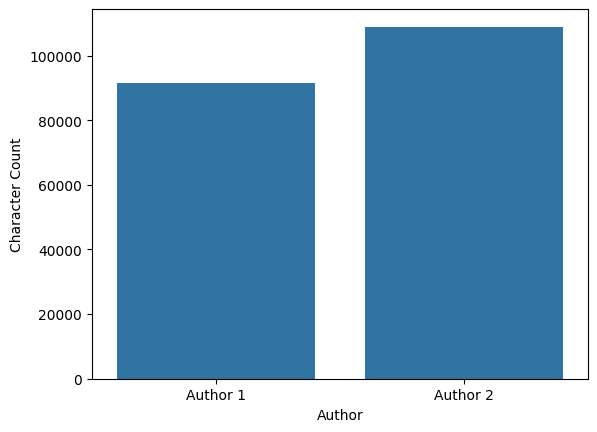

In [19]:
import seaborn as sns

author1_count = len(text)
author2_count = len(text2)

# Display the counts on a plot
import matplotlib.pyplot as plt

data = {'Author': ['Author 1', 'Author 2'], 'Character Count': [author1_count, author2_count]}
df = pd.DataFrame(data)

sns.barplot(x='Author', y='Character Count', data=df)
plt.show()

## Data loading, labeling and preprocessing
Load the data and convert the characters into one-hot encodings. Then load the data into a 3D NumPy array, with a shape of

* (batch, sequence_length, alphabet_length)

where sequence_length=60, and alphabet_length equals to the number of unique characters in both datasets. The sequences should be cut out from the complete dataset by sliding window. You should add 0 and 1 labels to the sequences, according to the author.

Later you may change sequence_length to achieve better results!

In [20]:
import numpy as np
import tensorflow as tf

#Define the sequence length and alphabet length
sequence_length = 60
combined_text = text + text2
alphabet = sorted(set(combined_text))
alphabet_length = len(alphabet)

#Create dictionaries for character to index and index to character mappings
char_to_index = {char: i for i, char in enumerate(alphabet)}
index_to_char = {i: char for i, char in enumerate(alphabet)}

#Initialize input_data and labels as NumPy arrays
input_data = np.zeros((len(combined_text) // sequence_length, sequence_length, alphabet_length))
labels = np.zeros((len(combined_text) // sequence_length, 1))

for i in range(0, len(text) + len(text2) - sequence_length, sequence_length):
    if(i + sequence_length < len(text)):
        for j in range(60):
            input_data[i//sequence_length, j, char_to_index[text[i+j]]] = 1
        labels[i//sequence_length] = 0
    else:
        for j in range(60):
            input_data[i//sequence_length, j, char_to_index[text2[i+j-len(text)]]] = 1
        labels[i//sequence_length] = 1

#Convert the input and label arrays to TensorFlow tensors
X = tf.convert_to_tensor(input_data, dtype=tf.float32)
Y = tf.convert_to_tensor(labels, dtype=tf.float32)

#Print the shapes of the input and label arrays
print("Input data shape:", X.shape)
print("Labels shape:", Y.shape)

Input data shape: (3340, 60, 92)
Labels shape: (3340, 1)


## Data splitting
Split the data into train, validate and test sets. Make

In [21]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

num_samples = len(X)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

train_data = X[:num_train]
val_data = X[num_train:num_train+num_val]
test_data = X[num_train+num_val:]

train_labels = Y[:num_train]
val_labels = Y[num_train:num_train+num_val]
test_labels = Y[num_train+num_val:]

print("Train data shape:", train_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_data.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (2338, 60, 92)
Train labels shape: (2338, 1)
Validation data shape: (501, 60, 92)
Validation labels shape: (501, 1)
Test data shape: (501, 60, 92)
Test labels shape: (501, 1)


## Model definition
Define a 1D CNN or an LSTM for the task. Compile the model with the correct loss function.

In [31]:
# Define the model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1],X.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)

(2338, 60, 92)
(2338, 1)
(501, 60, 92)
(501, 1)


## Model training
Train the model and apply early stopping.

In [33]:
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Train the model with early stopping
model.fit(train_data, train_labels,
          validation_data=(val_data, val_labels),
          epochs=10,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/10
74/74 [==============================] - 11s 115ms/step - loss: 0.6943 - accuracy: 0.6459 - val_loss: 1.1169 - val_accuracy: 0.0000e+00
Epoch 2/10
74/74 [==============================] - 7s 100ms/step - loss: 0.6304 - accuracy: 0.6501 - val_loss: 1.2180 - val_accuracy: 0.0020
Epoch 3/10
74/74 [==============================] - 6s 79ms/step - loss: 0.6217 - accuracy: 0.6583 - val_loss: 1.1304 - val_accuracy: 0.0559
Epoch 4/10
74/74 [==============================] - 7s 98ms/step - loss: 0.6171 - accuracy: 0.6574 - val_loss: 0.9420 - val_accuracy: 0.0579
Epoch 5/10
74/74 [==============================] - 6s 78ms/step - loss: 0.6030 - accuracy: 0.6728 - val_loss: 0.7446 - val_accuracy: 0.4850
Epoch 6/10
74/74 [==============================] - 7s 94ms/step - loss: 0.5976 - accuracy: 0.6873 - val_loss: 1.0893 - val_accuracy: 0.1277
Epoch 7/10
74/74 [==============================] - 6s 79ms/step - loss: 0.6176 - accuracy: 0.6818 - val_loss: 1.2185 - val_accuracy: 0.0519
Epoch 

## Evaluation on test data
Evaluate the model on the test data in terms of loss and accuracy.

In [34]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data, test_labels)

# Print the loss and accuracy
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

16/16 [==============================] - 0s 27ms/step - loss: 2.4627 - accuracy: 0.2914
Test Loss: 2.4627416133880615
Test Accuracy: 0.2914171516895294


## Confusion matrix
Calculate and display the confusion matrix.

In [41]:
# Make predictions on the test set
predictions = model.predict(test_data)
cm = confusion_matrix(test_labels, predictions)

# Draw the confusion matrix
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

16/16 [==============================] - 0s 29ms/step


TypeError: 'tensorflow.python.framework.ops.EagerTensor' object is not callable